In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Program Skripsi/data_teks.csv')
df

,Komentar,Label
0,Acara ini terasa kurang menarik dibandingkan g...,Kontra
1,"Peserta tidak terlihat siap, sehingga kompetis...",Kontra
2,Beberapa tantangan yang diberikan terlalu suli...,Kontra
3,"Meskipun konsepnya menarik, pelaksanaannya kur...",Kontra
4,"Penilaian juri terasa tidak objektif, sehingga...",Kontra
...,...,...
2995,"Acara Clash of Champions sangat memuaskan, sem...",Pro
2996,"Gue sangat senang nonton Clash of Champions, a...",Pro
2997,Penyelenggaraan Clash of Champions sangat baik...,Pro
2998,"Acara Clash of Champions sangat inspiratif, se...",Pro


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Contoh stopwords (bisa ditambah sesuai kebutuhan)
stop_words = set([
    'dan', 'di', 'yang', 'ke', 'dari', 'untuk', 'pada', 'dengan',
    'ini', 'itu', 'adalah', 'atau', 'saya', 'kami', 'kita'
])

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df['Cleaned'] = df['Komentar'].apply(preprocess_text)

In [ ]:
label_map = {'Pro': 2, 'Netral': 1, 'Kontra': 0}
df['Label'] = df['Label'].map(label_map)

In [ ]:
MAX_WORDS = None

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Cleaned'])

sequences = tokenizer.texts_to_sequences(df['Cleaned'])
MAX_LEN = max(len(seq) for seq in sequences)
vocab_size = min(len(tokenizer.word_index) + 1, 10000)

padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [ ]:
X = padded_sequences
y = df['Label'].values

# First, split train+temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Then, split temp into val + test (val 10%, test 20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MAX_LEN,)),
    tf.keras.layers.Embedding(vocab_size, 128),
    tf.keras.layers.GRU(160, return_sequences=True, dropout=0.2),
    tf.keras.layers.GRU(80, dropout=0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 58, 128)        │       202,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 58, 160)        │       139,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 80)             │        58,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,899 (1.54 MB)

 Trainable params: 404,899 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.3193 - loss: 1.1018 - val_accuracy: 0.3367 - val_loss: 1.0988
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3347 - loss: 1.1019 - val_accuracy: 0.3367 - val_loss: 1.0988
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3296 - loss: 1.0973 - val_accuracy: 0.3500 - val_loss: 1.0886
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4300 - loss: 1.0279 - val_accuracy: 0.6400 - val_loss: 0.7139
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6384 - loss: 0.6721 - val_accuracy: 0.6533 - val_loss: 0.5525
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6489 - loss: 0.5380 - val_accuracy: 0.5900 - val_loss: 0.7390
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6338 - loss: 0.6342 - val_accuracy: 0.6533 - val_loss: 0.5599
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6608 - loss: 0.5251 - val_accuracy: 0.6600 - 

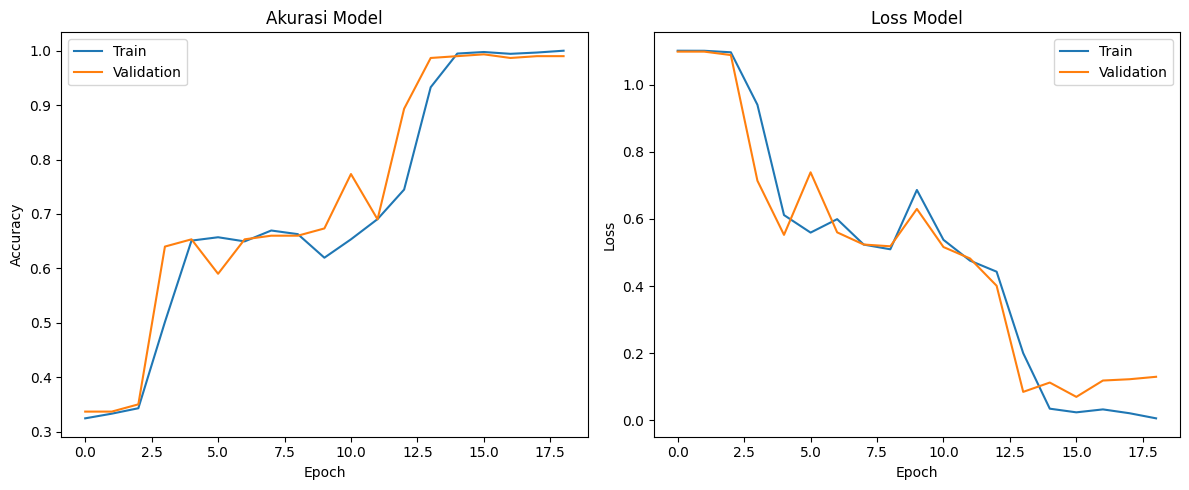

In [ ]:
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9895 - loss: 0.0728


In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


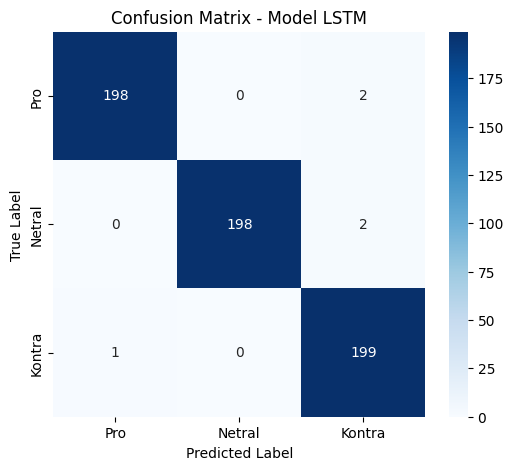

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pro', 'Netral', 'Kontra'], yticklabels=['Pro', 'Netral', 'Kontra'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Model LSTM')
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Pro', 'Netral', 'Kontra'], digits=3))

Classification Report:
              precision    recall  f1-score   support

         Pro      0.995     0.990     0.992       200
      Netral      1.000     0.990     0.995       200
      Kontra      0.980     0.995     0.988       200

    accuracy                          0.992       600
   macro avg      0.992     0.992     0.992       600
weighted avg      0.992     0.992     0.992       600

